In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id

spark = SparkSession.builder.appName("SteamRecommender").getOrCreate()

# Load the dataset
data_path = "/FileStore/tables/steam_200k.csv"
df = spark.read.csv(data_path, inferSchema=True, header=False) \
    .toDF("UserID", "Game", "Behavior", "Value")

# Show the first few rows
df.show()

# Initial exploratory analysis
df.describe().show()
df.groupBy("Behavior").count().show()


+---------+--------------------+--------+-----+
|   UserID|                Game|Behavior|Value|
+---------+--------------------+--------+-----+
|151603712|The Elder Scrolls...|purchase|  1.0|
|151603712|The Elder Scrolls...|    play|273.0|
|151603712|           Fallout 4|purchase|  1.0|
|151603712|           Fallout 4|    play| 87.0|
|151603712|               Spore|purchase|  1.0|
|151603712|               Spore|    play| 14.9|
|151603712|   Fallout New Vegas|purchase|  1.0|
|151603712|   Fallout New Vegas|    play| 12.1|
|151603712|       Left 4 Dead 2|purchase|  1.0|
|151603712|       Left 4 Dead 2|    play|  8.9|
|151603712|            HuniePop|purchase|  1.0|
|151603712|            HuniePop|    play|  8.5|
|151603712|       Path of Exile|purchase|  1.0|
|151603712|       Path of Exile|    play|  8.1|
|151603712|         Poly Bridge|purchase|  1.0|
|151603712|         Poly Bridge|    play|  7.5|
|151603712|         Left 4 Dead|purchase|  1.0|
|151603712|         Left 4 Dead|    play

In [0]:
from pyspark.sql.functions import sum, count

# Most frequently purchased games
purchased_games = df.filter(df.Behavior == 'purchase').groupBy('Game').count().orderBy('count', ascending=False)

# Games with the highest total play time
playtime_games = df.filter(df.Behavior == 'play').groupBy('Game').agg(sum('Value').alias('Total_Play_Time')).orderBy('Total_Play_Time', ascending=False)


In [0]:
# Collect the top N for visualization to avoid OOM errors
top_purchased_games = purchased_games.limit(10).collect()
top_playtime_games = playtime_games.limit(10).collect()


In [0]:
import matplotlib.pyplot as plt

# Function to plot the most frequently purchased games
def plot_top_purchased_games(data):
    games = [row['Game'] for row in data]
    counts = [row['count'] for row in data]
    
    plt.figure(figsize=(10, 6))
    plt.barh(games, counts, color='skyblue')
    plt.xlabel('Number of Purchases')
    plt.ylabel('Game')
    plt.title('Top 10 Most Frequently Purchased Games')
    plt.gca().invert_yaxis()  # Invert y-axis to have the game with the highest count on top
    plt.show()

# Function to plot the games with the highest total play time
def plot_top_playtime_games(data):
    games = [row['Game'] for row in data]
    play_times = [row['Total_Play_Time'] for row in data]
    
    plt.figure(figsize=(10, 6))
    plt.barh(games, play_times, color='lightgreen')
    plt.xlabel('Total Play Time')
    plt.ylabel('Game')
    plt.title('Top 10 Games with the Highest Total Play Time')
    plt.gca().invert_yaxis()
    plt.show()



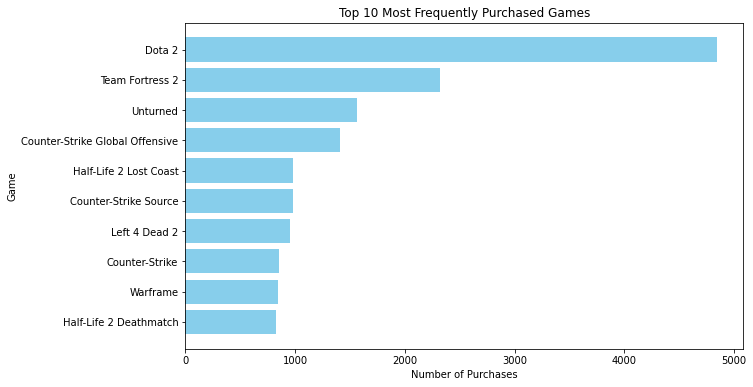

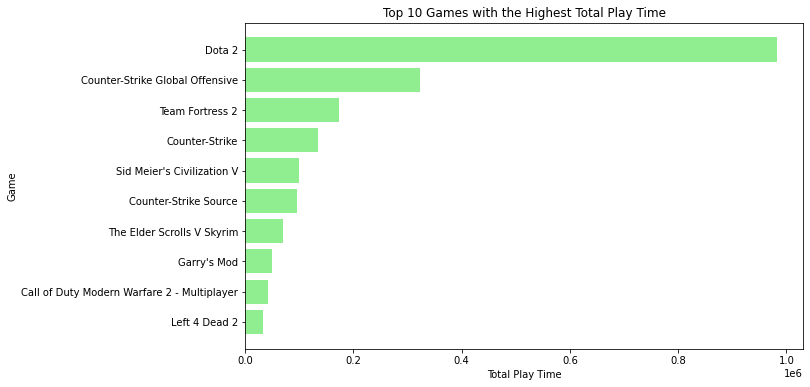

In [0]:
# Plotting
plot_top_purchased_games(top_purchased_games)
plot_top_playtime_games(top_playtime_games)


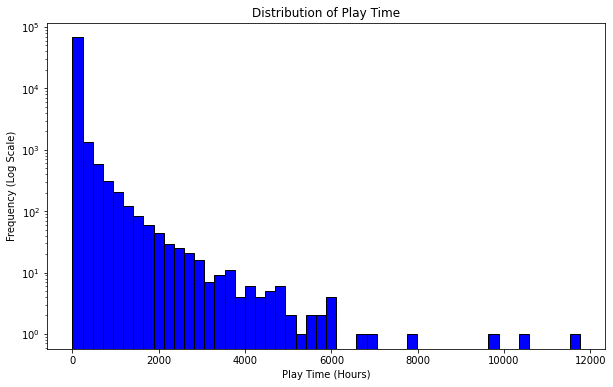

In [0]:
play_times = df.filter(df.Behavior == 'play').select('Value').collect()
play_times_list = [float(row['Value']) for row in play_times]

plt.figure(figsize=(10, 6))
plt.hist(play_times_list, bins=50, color='blue', edgecolor='black', log=True)
plt.title('Distribution of Play Time')
plt.xlabel('Play Time (Hours)')
plt.ylabel('Frequency (Log Scale)')
plt.show()


In [0]:
df.filter(df.Behavior == "purchase").groupBy("Game").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|                Game|count|
+--------------------+-----+
|              Dota 2| 4841|
|     Team Fortress 2| 2323|
|            Unturned| 1563|
|Counter-Strike Gl...| 1412|
|Half-Life 2 Lost ...|  981|
|Counter-Strike So...|  978|
|       Left 4 Dead 2|  951|
|      Counter-Strike|  856|
|            Warframe|  847|
|Half-Life 2 Death...|  823|
|         Garry's Mod|  731|
|The Elder Scrolls...|  717|
|           Robocraft|  689|
|Counter-Strike Co...|  679|
|Counter-Strike Co...|  679|
|   Heroes & Generals|  658|
|         Half-Life 2|  639|
|Sid Meier's Civil...|  596|
|         War Thunder|  590|
|              Portal|  588|
+--------------------+-----+
only showing top 20 rows



In [0]:
df.filter(df.Behavior == "play").groupBy("Game").sum("Value").orderBy("sum(Value)", ascending=False).show()


+--------------------+------------------+
|                Game|        sum(Value)|
+--------------------+------------------+
|              Dota 2| 981684.5999999999|
|Counter-Strike Gl...| 322771.6000000001|
|     Team Fortress 2|173673.30000000005|
|      Counter-Strike|134261.09999999998|
|Sid Meier's Civil...| 99821.30000000002|
|Counter-Strike So...| 96075.50000000003|
|The Elder Scrolls...|           70889.3|
|         Garry's Mod|           49725.3|
|Call of Duty Mode...|42009.899999999994|
|       Left 4 Dead 2|33596.700000000004|
|Football Manager ...|           32308.6|
|Football Manager ...|30845.799999999996|
|Football Manager ...|           30574.8|
|            Terraria|29951.799999999996|
|            Warframe|           27074.6|
|Football Manager ...|           24283.1|
|              Arma 3|           24055.7|
|  Grand Theft Auto V|22956.699999999997|
|       Borderlands 2|           22667.9|
|    Empire Total War|21030.300000000003|
+--------------------+------------

In [0]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

# Assign unique IDs to games
games_df = df.select("Game").distinct().withColumn("GameID", row_number().over(Window.orderBy("Game")))

# Join back to get GameID for each record
df_with_game_id = df.join(games_df, ["Game"], "left")



In [0]:
(training, test) = df_with_game_id.randomSplit([0.8, 0.2])

In [0]:
from pyspark.ml.recommendation import ALS

# Assuming 'training' is your training dataset DataFrame prepared earlier
als = ALS(userCol="UserID", itemCol="GameID", ratingCol="Value", coldStartStrategy="drop", nonnegative=True)
model = als.fit(training)

In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 195.01059034258472


In [0]:
userRecs = model.recommendForAllUsers(5)
userRecs.show()


+--------+--------------------+
|  UserID|     recommendations|
+--------+--------------------+
|   76767|[{982, 2557.5005}...|
|  144736|[{1761, 75.52917}...|
|  229911|[{1621, 160.47937...|
|  835015|[{1459, 95.11412}...|
|  948368|[{1459, 80.02161}...|
|  975449|[{1761, 1003.2868...|
| 1268792|[{1459, 83.4808},...|
| 2531540|[{1560, 56.427288...|
| 2753525|[{1560, 532.16266...|
| 3450426|[{1621, 74.57}, {...|
| 7923954|[{1459, 91.42903}...|
| 7987640|[{1459, 139.78433...|
| 8259307|[{1761, 91.770645...|
| 8567888|[{1459, 202.87639...|
| 8585433|[{1459, 2912.2961...|
| 8784496|[{1459, 408.34702...|
| 8795607|[{1560, 667.1149}...|
|10144413|[{1459, 213.16098...|
|10595342|[{1459, 3182.145}...|
|10599862|[{1459, 1155.4126...|
+--------+--------------------+
only showing top 20 rows



In [0]:
#pip install mlflow

In [0]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

#  hyperparameters
rank = 10
maxIter = 5
regParam = 0.01

als = ALS(
    userCol="UserID",
    itemCol="GameID",
    ratingCol="Value",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=rank,
    maxIter=maxIter,
    regParam=regParam
)

model = als.fit(training)


In [0]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Value", predictionCol="prediction")

rmse = evaluator.evaluate(predictions)
print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 285.8890068909522


In [0]:
import mlflow
import mlflow.spark

with mlflow.start_run():
    # Log hyperparameters
    mlflow.log_param("rank", rank)
    mlflow.log_param("maxIter", maxIter)
    mlflow.log_param("regParam", regParam)
    
    # Log the RMSE metric
    mlflow.log_metric("rmse", rmse)
    
    # Log the ALS model
    mlflow.spark.log_model(model, "als_model")


2024/03/02 10:36:46 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/03/02 10:37:14 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/1984904149683525/7f4922e1492b4d4a8e27c76a25241cc7/artifacts/als_model/sparkml, flavor: spark). Fall back to return ['pyspark==3.3.2', 'pandas<2']. Set logging level to DEBUG to see the full traceback. 
/databricks/python/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [0]:
best_rmse = float("inf")
best_rank = 0
best_regParam = 0

for rank in [5, 10, 15]:
    for regParam in [0.01, 0.1, 1.0]:
        als = ALS(
            userCol="UserID",
            itemCol="GameID",
            ratingCol="Value",
            coldStartStrategy="drop",
            nonnegative=True,
            rank=rank,
            maxIter=5,
            regParam=regParam
        )
        
        model = als.fit(training)
        predictions = model.transform(test)
        rmse = evaluator.evaluate(predictions)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_rank = rank
            best_regParam = regParam
            
        # Log each experiment with MLflow
        with mlflow.start_run():
            mlflow.log_params({"rank": rank, "regParam": regParam})
            mlflow.log_metric("rmse", rmse)
            mlflow.spark.log_model(model, f"als_model_rank_{rank}_regParam_{regParam}")

print(f"Best RMSE: {best_rmse} with Rank: {best_rank} and RegParam: {best_regParam}")


2024/03/02 10:37:56 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/03/02 10:38:24 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: dbfs:/databricks/mlflow-tracking/1984904149683525/5abd406e699643d9920f9db2d84c674f/artifacts/als_model_rank_5_regParam_0.01/sparkml, flavor: spark). Fall back to return ['pyspark==3.3.2', 'pandas<2']. Set logging level to DEBUG to see the full traceback. 
2024/03/02 10:39:05 INFO mlflow.spark: Inferring pip requirements by reloading the logged model from the databricks artifact repository, which can be time-consuming. To speed up, explicitly specify the conda_env or pip_requirements when calling log_model().
2024/03/02 10:39:33 WARNING mlflow.utils.environment: Encountered an unexpected error while infer

Best RMSE: 174.50940661394282 with Rank: 5 and RegParam: 1.0


In [0]:
predictions.select("UserID", "GameID", "Value", "prediction").show()

+---------+------+-----+----------+
|   UserID|GameID|Value|prediction|
+---------+------+-----+----------+
| 86055705|     2|  1.0|0.33450413|
| 65117175|     3|  1.2|0.58336604|
| 78560022|     3|  1.0|0.20872264|
| 33013552|     4|  1.0| 1.5953434|
| 93644606|     6|  1.0|  7.160867|
| 39037163|     8|  0.2|0.81591535|
| 73835640|     9|  1.0|  4.245926|
| 84471496|     9|  0.1| 1.0364599|
|146999982|     9|  0.2| 1.2991487|
|193156880|     9|  1.0| 0.5189666|
| 73835640|    10|  1.0|   3.28762|
| 24721232|    11|  1.0|  8.692416|
| 30246419|    11|  1.2|0.35587582|
|120523185|    11|  2.0| 0.5653712|
|147602462|    12|  0.5|0.85852295|
|231808839|    13|  1.0|0.08905247|
| 92914917|    14|  4.2|0.83248895|
| 65398650|    18|  1.0| 0.2844442|
|138941587|    23|  4.7|0.83814317|
|  1950243|    26|  1.0|  4.216858|
+---------+------+-----+----------+
only showing top 20 rows

